In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm



In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

100%|██████████| 170M/170M [00:02<00:00, 62.2MB/s]


In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
  img = img / 2 + 0.5
  npimg = img.numpy()
  return np.transpose(npimg, (1, 2, 0)).astype(np.float32)

#Train Loader iterable

train_features_batch, train_labels_batch = next(iter(trainloader))
train_features_batch.shape, train_labels_batch.shape

print(f"DataLoaders: {trainloader,testloader }")
print(f"Length of train_dataloader: {len(trainloader)} batches of {trainloader.batch_size}...")
print(f"Length of test_dataloader: {len(testloader)} batches of {testloader.batch_size}...")



DataLoaders: (<torch.utils.data.dataloader.DataLoader object at 0x7cbddf345810>, <torch.utils.data.dataloader.DataLoader object at 0x7cbd82dec9d0>)
Length of train_dataloader: 782 batches of 64...
Length of test_dataloader: 79 batches of 128...


In [ ]:
class MLP_cifar10(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(32 * 32 * 3, 1536)  # Capa oculta 1 32*32 * (3 canales) pixeles = 3072
    self.relu1 = nn.ReLU()
    self.fc2 = nn.Linear(1536, 768)  # Capa oculta 2
    self.relu2 = nn.ReLU()
    self.fc3 = nn.Linear(768, 10)  # Capa de salida (10 clases)

  def forward(self, x):

    x = self.fc1(x)
    x = self.relu1(x)
    x = self.fc2(x)
    x = self.relu2(x)
    x = self.fc3(x)
    return x

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model_cifar10 = MLP_cifar10().to(device)

#Adam Optimizer (Adaptive learning rate)
optimizer = optim.Adam(model_cifar10.parameters(), lr=0.001)

#Loss Function
loss_fn = nn.CrossEntropyLoss()


parameters = sum(p.numel() for p in model_cifar10.parameters() if p.requires_grad)
print(model_cifar10)
print("Model trainable parameters: ", parameters)

MLP_cifar10(
  (fc1): Linear(in_features=3072, out_features=1536, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=1536, out_features=768, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=768, out_features=10, bias=True)
)
Model trainable parameters:  5908234


In [ ]:
train_features_batch.shape

torch.Size([64, 3, 32, 32])

In [ ]:
import urllib.request

url = "https://github.com/Gilberter/Hands-on-Computer-Vision/raw/refs/heads/main/sesiones/Proyecto/model_cifar10_weights.pth"
nombre_archivo = 'model_cifar10_weights.pth'
try:
    urllib.request.urlretrieve(url, nombre_archivo)
    print(f"Archivo descargado correctamente como '{nombre_archivo}'")
except Exception as e:
    print(f"Error al descargar el archivo: {e}")

Archivo descargado correctamente como 'model_cifar10_weights.pth'


In [ ]:

weights_path = 'model_cifar10_weights.pth'
state_dict = torch.load(weights_path, map_location=device)
model_cifar10.load_state_dict(state_dict)


<All keys matched successfully>

# Entrenar modelo solo 5 epocas *NO EJECUTAR YA ESTA ENTRENADO*


In [ ]:
# Set the model to training mode.
model_cifar10.train()
epochs = 5
# For it epoch
for epoch in range(epochs):
    avg_loss_epoch = 0
    batch_loss = 0
    total_batches = 0

    for batch_num, batch in enumerate(tqdm(trainloader, desc = f"Epoch {epoch}:")):
        batch = tuple(b.to(device) for b in batch)
        images, labels = batch
        optimizer.zero_grad()

        images = images.view(images.size(0), -1) # Hazle un reshape a las imagenes para coincidir con las dimensiones de entrada
        outputs = model_cifar10(images) # Obten la salida de tu modelo
        loss = loss_fn(outputs, labels) # Calcula la funcion de perdida en base a la salida de tu modelo
        loss.backward()
        optimizer.step()

        total_batches += 1
        batch_loss += loss.item()

    avg_loss_epoch = batch_loss/total_batches
    print ('Epoch [{}/{}], Average Loss for epoch {}: {:.4f}'
                .format(epoch+1, epochs, epoch+1, avg_loss_epoch))

Epoch 0:: 100%|██████████| 782/782 [01:07<00:00, 11.62it/s]


Epoch [1/5], Average Loss for epoch 1: 1.6588


Epoch 1:: 100%|██████████| 782/782 [01:13<00:00, 10.66it/s]


Epoch [2/5], Average Loss for epoch 2: 1.4601


Epoch 2:: 100%|██████████| 782/782 [01:13<00:00, 10.66it/s]


Epoch [3/5], Average Loss for epoch 3: 1.3527


Epoch 3:: 100%|██████████| 782/782 [01:13<00:00, 10.70it/s]


Epoch [4/5], Average Loss for epoch 4: 1.2549


Epoch 4:: 100%|██████████| 782/782 [01:15<00:00, 10.31it/s]

Epoch [5/5], Average Loss for epoch 5: 1.1732


In [ ]:
# Save the trained model weights
torch.save(model_cifar10.state_dict(), 'model_cifar10_weights.pth')

# Ejecutar funciones

In [16]:
# Load these weights back into a model later

In [17]:
# Evaluate The Model
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

imagetest, labeltest = next(iter(testloader))
print(imagetest.shape)
print(labeltest.shape)

torch.Size([128, 3, 32, 32])
torch.Size([128])


In [18]:
def evaluate_model(model, data_loader):
    loss,acc = 0,0   # Loss and accuracy
    model.eval()     # Evaluation mode
    with torch.no_grad(): # No changes in gradient calculation
      for x_test, y_test in data_loader:  # Iterates through each batch of data
        x_test = x_test.to(device)
        y_test = y_test.to(device)
        x_test = x_test.view(x_test.size(0), -1) #Single vector no dimensionality

         # get logits of all the classes
        if (model.__class__.__name__ == "MLP_cifar10"):
          y_logits = model(x_test)

        else:
          y_logits = model.base_model.forward(x_test)
        y_pred = torch.argmax(y_logits, dim=1) #Get predicted class with the hightes logit value

        loss += loss_fn(y_logits, y_test) #Calculate loss
        acc += accuracy_fn(y_test, y_pred) #Calculate accuracy

    loss /= len(data_loader)
    acc /= len(data_loader)
    return {"model_name": model.__class__.__name__,
            "model_loss": loss.item(),
            "model_acc": acc}

In [19]:
# This function only accepts 9 images

def model_predictions(model: torch.nn.Module,
                      data: list
                      ):
  pred_prob = []
  model.eval()
  with torch.no_grad():
    data = data.to(device)
    x = data.view(data.size(0), -1)  # Get a [9,3072] #data,size(0) -> gets the number of images in th batch
    y_logits = model(x)        # Get the logit predictions of the model

    pred_prob = torch.softmax(y_logits, dim=1)

  return pred_prob

In [20]:
import random
test_samples = []
test_labels = []
for sample, label in random.sample(list(testset), k=9):
  test_samples.append(sample)
  test_labels.append(label)
test_samples[0].shape
#Cannot work with this set i need ["amount of images","channels","width","height"]

torch.Size([3, 32, 32])

In [21]:
test_samples = torch.stack(test_samples)
test_samples.shape

torch.Size([9, 3, 32, 32])

In [22]:
pred_probs = model_predictions(model=model_cifar10,
                              data=test_samples,
                              )

In [23]:
print(pred_probs.shape)
# 9 uimages 10 labels
pred_class = torch.argmax(pred_probs, dim=1)
print(pred_class) # Preticted label for each image

# Labels order in the data set
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


torch.Size([9, 10])
tensor([8, 0, 5, 9, 5, 8, 7, 5, 9])


In [24]:
# Random bach of images
import random
random.seed(1)
test_samples = []
test_labels = []
count_image = 0;
for sample, label in random.sample(list(testset), k=15):
  test_samples.append(sample)
  test_labels.append(label)

test_samples = torch.stack(test_samples)

pred_probs = model_predictions(model=model_cifar10,
                              data=test_samples,
                              )
pred_class = torch.argmax(pred_probs, dim=1)
labels = test_labels

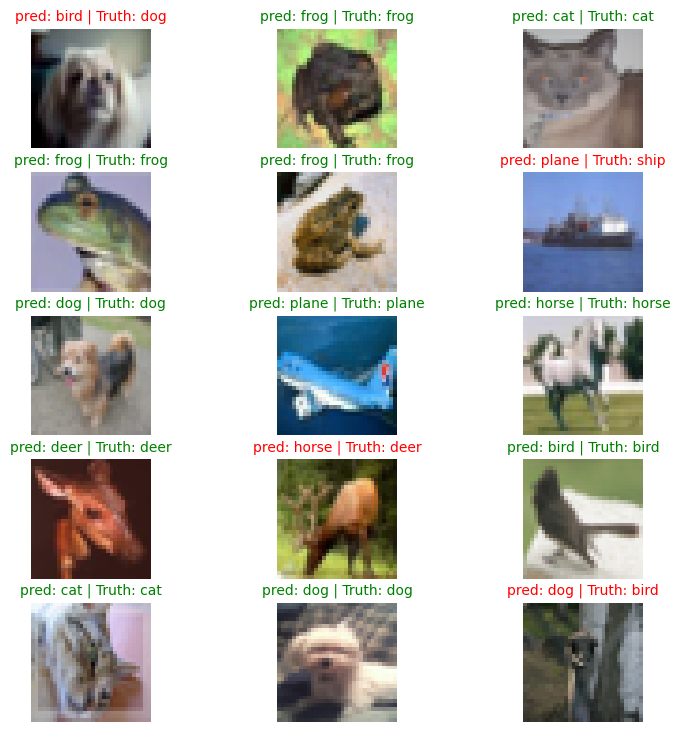

In [25]:
# NO modifiques esta celda ♥
plt.figure(figsize=(9,9))
nrows = 5
ncols = 3
for i, sample in enumerate(test_samples):
  plt.subplot(nrows, ncols, i+1)

  #plot the target image
  plt.imshow(imshow(test_samples[i]))

  #find the prediction label
  pred_label = classes[pred_class[i]]

  #get the truth label
  truth_label = classes[labels[i]]

  #create a tittle for the plot
  tittle_text = f"pred: {pred_label} | Truth: {truth_label}"
  if pred_label == truth_label:
    plt.title(tittle_text, fontsize=10,c="g")
  else:
    plt.title(tittle_text, fontsize=10,c="r")
  plt.axis(False)

# PEFT y LoRA

In [26]:
%%capture
!pip install peft


In [27]:
from peft import LoraConfig, get_peft_model, TaskType
from peft.tuners.lora import LoraModel


In [29]:
# LoRA configuration
# Create LoRA config
lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["fc1", "fc2"],  # Choose the layers you want to adapt
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.FEATURE_EXTRACTION  # MLP isn't a Transformer/CAUSAL_LM
)

# Load base model
model = MLP_cifar10()
model.load_state_dict(torch.load("model_cifar10_weights.pth"))

# Apply LoRA
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()


trainable params: 55,296 || all params: 5,963,530 || trainable%: 0.9272


In [30]:
# TRAINING PEFT MODEL PARAMETERES IN THE DATA CATS VS DOGS
from torch.utils.data import TensorDataset, random_split, DataLoader

data_dogs_vs_cats = []
data_labels_dogs_vs_cats = []
dogs_image = 0;
cats_image = 0;
for sample, label in random.sample(list(testset), k=1000):
  if cats_image < 500 and label == 3:
    data_dogs_vs_cats.append(sample)
    data_labels_dogs_vs_cats.append(label)
    cats_image += 1
  elif dogs_image < 500 and label == 5:
    data_dogs_vs_cats.append(sample)
    data_labels_dogs_vs_cats.append(label)
    dogs_image += 1

data_dogs_vs_cats = torch.stack(data_dogs_vs_cats)
data_labels_dogs_vs_cats = torch.tensor(data_labels_dogs_vs_cats)

full_dataset = TensorDataset(data_dogs_vs_cats, data_labels_dogs_vs_cats)
total_size = len(full_dataset)
train_size = int(total_size * 0.8) # Example: 80% for training
test_size = total_size - train_size

#Data set tensor
train_dogs_vs_cats, test_dogs_vs_cats = random_split(full_dataset, [train_size, test_size])

#Data set Loader
train_dogs_vs_cats_loader = DataLoader(train_dogs_vs_cats, batch_size=10, shuffle=True)
test_dogs_vs_cats_loader = DataLoader(test_dogs_vs_cats, batch_size=10, shuffle=False)

# Train loader iterable batches
train_dogs_vs_cats_batch, train_dogs_vs_cats_labels_batch = next(iter(train_dogs_vs_cats_loader))


print(f"Length of train_dataloader: {len(train_dogs_vs_cats_loader)} batches of {train_dogs_vs_cats_loader.batch_size}...")
print(f"Length of test_dataloader: {len(train_dogs_vs_cats_loader)} batches of {train_dogs_vs_cats_loader.batch_size}...")


Length of train_dataloader: 18 batches of 10...
Length of test_dataloader: 18 batches of 10...


Text(0.5, 1.0, 'cat')

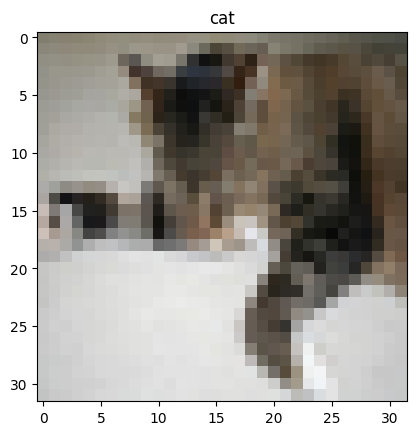

In [31]:
img = train_dogs_vs_cats_batch[9]
img.shape
plt.imshow(imshow(img))
plt.title(classes[train_dogs_vs_cats_labels_batch[9]])

In [32]:
# Set the model to training mode.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
model.train()
epochs = 20
# For it epoch
for epoch in range(epochs):
    avg_loss_epoch = 0
    batch_loss = 0
    total_batches = 0

    for batch_num, batch in enumerate(tqdm(train_dogs_vs_cats_loader, desc = f"Epoch {epoch}:")):
        batch = tuple(b.to(device) for b in batch)
        images, labels = batch
        optimizer.zero_grad()

        images = images.view(images.size(0), -1) # Hazle un reshape a las imagenes para coincidir con las dimensiones de entrada
        outputs = model.base_model.forward(images) # Obten la salida de tu modelo
        loss = loss_fn(outputs, labels) # Calcula la funcion de perdida en base a la salida de tu modelo
        loss.backward()
        optimizer.step()

        total_batches += 1
        batch_loss += loss.item()

    avg_loss_epoch = batch_loss/total_batches
    print ('Epoch [{}/{}], Average Loss for epoch {}: {:.4f}'
                .format(epoch+1, epochs, epoch+1, avg_loss_epoch))

Epoch 0:: 100%|██████████| 18/18 [00:00<00:00, 62.32it/s]


Epoch [1/20], Average Loss for epoch 1: 1.4056


Epoch 1:: 100%|██████████| 18/18 [00:00<00:00, 93.86it/s]


Epoch [2/20], Average Loss for epoch 2: 0.8064


Epoch 2:: 100%|██████████| 18/18 [00:00<00:00, 99.36it/s]


Epoch [3/20], Average Loss for epoch 3: 0.5791


Epoch 3:: 100%|██████████| 18/18 [00:00<00:00, 108.44it/s]


Epoch [4/20], Average Loss for epoch 4: 0.4897


Epoch 4:: 100%|██████████| 18/18 [00:00<00:00, 90.80it/s]


Epoch [5/20], Average Loss for epoch 5: 0.4108


Epoch 5:: 100%|██████████| 18/18 [00:00<00:00, 69.65it/s]


Epoch [6/20], Average Loss for epoch 6: 0.3830


Epoch 6:: 100%|██████████| 18/18 [00:00<00:00, 68.75it/s]


Epoch [7/20], Average Loss for epoch 7: 0.3314


Epoch 7:: 100%|██████████| 18/18 [00:00<00:00, 77.85it/s]


Epoch [8/20], Average Loss for epoch 8: 0.3120


Epoch 8:: 100%|██████████| 18/18 [00:00<00:00, 77.46it/s]


Epoch [9/20], Average Loss for epoch 9: 0.2627


Epoch 9:: 100%|██████████| 18/18 [00:00<00:00, 73.95it/s]


Epoch [10/20], Average Loss for epoch 10: 0.2241


Epoch 10:: 100%|██████████| 18/18 [00:00<00:00, 72.57it/s]


Epoch [11/20], Average Loss for epoch 11: 0.1775


Epoch 11:: 100%|██████████| 18/18 [00:00<00:00, 75.96it/s]


Epoch [12/20], Average Loss for epoch 12: 0.1843


Epoch 12:: 100%|██████████| 18/18 [00:00<00:00, 72.84it/s]


Epoch [13/20], Average Loss for epoch 13: 0.2231


Epoch 13:: 100%|██████████| 18/18 [00:00<00:00, 68.29it/s]


Epoch [14/20], Average Loss for epoch 14: 0.2262


Epoch 14:: 100%|██████████| 18/18 [00:00<00:00, 67.98it/s]


Epoch [15/20], Average Loss for epoch 15: 0.1585


Epoch 15:: 100%|██████████| 18/18 [00:00<00:00, 68.31it/s]


Epoch [16/20], Average Loss for epoch 16: 0.1371


Epoch 16:: 100%|██████████| 18/18 [00:00<00:00, 75.15it/s]


Epoch [17/20], Average Loss for epoch 17: 0.1265


Epoch 17:: 100%|██████████| 18/18 [00:00<00:00, 103.08it/s]


Epoch [18/20], Average Loss for epoch 18: 0.0896


Epoch 18:: 100%|██████████| 18/18 [00:00<00:00, 102.97it/s]


Epoch [19/20], Average Loss for epoch 19: 0.0740


Epoch 19:: 100%|██████████| 18/18 [00:00<00:00, 104.77it/s]

Epoch [20/20], Average Loss for epoch 20: 0.0591


In [33]:
from peft import PeftModel

# Save just the LoRA adapter
model.save_pretrained("mlp_lora_cats_dogs")

In [35]:
from peft import PeftModel, PeftConfig

# Load original base model
base_model = MLP_cifar10()
base_model.load_state_dict(torch.load("model_cifar10_weights.pth"))

# Load LoRA adapter
peft_model = PeftModel.from_pretrained(base_model, "mlp_lora_cats_dogs")
peft_model.eval()

PeftModelForFeatureExtraction(
  (base_model): LoraModel(
    (model): MLP_cifar10(
      (fc1): lora.Linear(
        (base_layer): Linear(in_features=3072, out_features=1536, bias=True)
        (lora_dropout): ModuleDict(
          (default): Dropout(p=0.1, inplace=False)
        )
        (lora_A): ModuleDict(
          (default): Linear(in_features=3072, out_features=8, bias=False)
        )
        (lora_B): ModuleDict(
          (default): Linear(in_features=8, out_features=1536, bias=False)
        )
        (lora_embedding_A): ParameterDict()
        (lora_embedding_B): ParameterDict()
        (lora_magnitude_vector): ModuleDict()
      )
      (relu1): ReLU()
      (fc2): lora.Linear(
        (base_layer): Linear(in_features=1536, out_features=768, bias=True)
        (lora_dropout): ModuleDict(
          (default): Dropout(p=0.1, inplace=False)
        )
        (lora_A): ModuleDict(
          (default): Linear(in_features=1536, out_features=8, bias=False)
        )
        (lo

In [36]:
model_results = evaluate_model(peft_model, test_dogs_vs_cats_loader)
print(model_results)
model_results = evaluate_model(peft_model, testloader)
print(model_results)


{'model_name': 'PeftModelForFeatureExtraction', 'model_loss': 1.183201551437378, 'model_acc': 59.33333333333333}
{'model_name': 'PeftModelForFeatureExtraction', 'model_loss': 17.42734146118164, 'model_acc': 13.103243670886076}


In [37]:
model_results = evaluate_model(model_cifar10, testloader)
print(model_results)
model_results = evaluate_model(model_cifar10, test_dogs_vs_cats_loader)
print(model_results)

{'model_name': 'MLP_cifar10', 'model_loss': 1.4354486465454102, 'model_acc': 51.157041139240505}
{'model_name': 'MLP_cifar10', 'model_loss': 1.7463010549545288, 'model_acc': 36.666666666666664}


Conclusion

Usando el modelo ya entrenado y usando el nuevo modelo peft_model gracais a la libreria PEFT y el modelo LoRA los nuevos parametros aprendidos para clasificar de mejor manera a perros y gatos aumento su accuraccy a 60%.

En cambio el modelo MLP_cifar10 clasifica con un acuraccy de 37%.